# 1. Problem Definition
When an employee at any company starts work, they first need to obtain the computer access necessary to fulfill their role. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). A knowledgeable supervisor then takes time to manually grant the needed access in order to overcome access obstacles. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

There is a considerable amount of data regarding an employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

# 2. Objective
The objective of this competition is to build a model, learned using historical data, that will determine an employee's access needs, such that manual access transactions (grants and revokes) are minimized as the employee's attributes change over time. The model will take an employee's role information and a resource code and will return whether or not access should be granted.

# 3. Solution Approach
 The problem needs to treated as a classification problem as the final goal is to determine whether a employee should be a given access ('1) or not ('0'). After importing all the necessary packages for data pre-processing, visualization and modeling, a quick inspection of the data shows that all the features in the dataset are categorical and none of them has any null features. This means that  the solution approach does not require any of the pre- processing steps that are usually followed for handling missing values in a dataset. To identify features that are critical for modeling,  a feature selection step is performed using the univariate selection method from available scikit modules. Once the top 6 significant features are idenitified and uncenssary features are eliminated from the dataset,  a hashing trick was applied to encode those categorical features prior applying different machine learning models to the dataset. Four different classification were then applied on the training dataset and the best performing model was then selected based on the cross validation scores. Efficiency of the best model in predicting the test data is then evaluated based on ROC and AUC curves. To detemine if the approach adopted above has any benifit in terms of improving prediction accuracy, random forest model is also applied on the training dataset without doing any preprocssing (i.e. no feature selection or feature engineering) and REC\AUC is compared with the first approach. The importance of the features are then ranked to check whether both  approaches consider the same features to be insignificant.  Details of all the steps and necessary codes are discussed below.

> * **Importing packages for preprocssing, visualization and modeling **

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Import packages for modeling and performance evaulation
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


#Data Visualization Packages
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from collections import Counter

#Import Packages for Feature Selection
##Univariate feature selection
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.feature_selection import chi2

#Import package for encoding categorical features 
import category_encoders as ce

# Import package calculate accuracy
from sklearn import metrics

#Import package for splitting the dataset
from sklearn.model_selection import train_test_split


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sampleSubmission.csv', 'test.csv']


>* **Importing training and test data**

Since its an old competition,it is not possible to evaluate the prediction using the test.csv dataset provided by amazon. Therefore, this problem is solved by splitting the train.csv dataset 50/50 for training and evaluation on unseen data. Once the best perofrming model is identified using 50% of the train.csv dataset, the remaining 50% of the data is used for testing performance of the model using ROC_AUC score as the metric. 

In [16]:
train = pd.read_csv('../input/train.csv')
X1=train.drop(["ACTION"],axis = 1)
y1=train['ACTION']

train_X, test_X, train_Y, test_Y = train_test_split(X1, y1, test_size=0.5, random_state=42)


>* **Quick inspection of train and test data**

In [17]:
train_X.head(5)

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
16886,22390,4757,118212,118213,118458,119849,290535,118638,119851
23698,23968,17319,117961,117962,118791,121469,310997,118424,121471
22858,19310,47858,5110,117954,117895,117885,133128,117887,117888
12090,42388,15887,117961,118052,120356,120357,127906,118424,120359
14241,41642,4084,117961,118052,118992,118321,117906,290919,118322


In [18]:
test_X.head(5)

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
18245,37793,81744,117902,117903,118783,118451,130134,118453,118454
9226,40309,1541,117961,118225,123173,119093,123174,119095,119096
27195,27356,205,117961,118386,118746,118784,147114,290919,118786
6478,5173,8229,117961,118300,121305,119351,149246,3130,119353
4813,77207,51791,117961,119256,120943,118995,280788,292795,118997


In [ ]:
train_X.info()

In [ ]:
test_X.info()

# 4. Feature Selection
[Feature selection algorithms](https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/) help to determine which features significantly influence the output variable  and then eliminate the remaining  features from consideration. This step is particularly useful for dealing with datasets that has  large number of features as it reduces the complexity of the model  by reducing the data and enables machine learning algortihms to train faster. The scikit module provides [several ways](https://scikit-learn.org/stable/modules/feature_selection.html) for identifying significant features either by evaluating the statistical correlation with the outcome variable (e.g. univariate feature selection method )  or by measuring  the usefulness of a subset of feature by actually training a machine learning model on it (e.g. recursive feature elimination). Considering the size of this particular dataset and the computational time usually required for recursive feature elimination, the universal feature seleciton method is adopted for the first trial. 

>* **Applying univariate feature selection methods to the train data**

In [19]:

selector = SelectKBest(chi2, k=6)
X_new=selector.fit_transform(train_X, train_Y)
mask = selector.get_support(indices=True)
colname = train_X.columns[mask]
colname

Index(['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_TITLE', 'ROLE_FAMILY_DESC',
       'ROLE_FAMILY'],
      dtype='object')

Now that the top 6 significant features have been identified, the remaining features will be dropped from both the training and test dataset. To minimize coding efforts,  a good approach  is to concatenate train and test data to a single dataset prior preprocessing. 

>* **Concatenating train and test data into a single dataset**

In [20]:
dataset = pd.concat([train_X, test_X])
dataset.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
16886,22390,4757,118212,118213,118458,119849,290535,118638,119851
23698,23968,17319,117961,117962,118791,121469,310997,118424,121471
22858,19310,47858,5110,117954,117895,117885,133128,117887,117888
12090,42388,15887,117961,118052,120356,120357,127906,118424,120359
14241,41642,4084,117961,118052,118992,118321,117906,290919,118322


Now, lets drop the features 'RESOURCE', 'ROLE_ROLLUP_1',and 'ROLE_DEPTNAME' from the dataset. 

>* **Dropping features from dataset**

In [21]:
dataset = dataset.drop(columns=['RESOURCE','ROLE_ROLLUP_2','ROLE_DEPTNAME'],axis=1)
dataset.head(5)

,MGR_ID,ROLE_ROLLUP_1,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
16886,4757,118212,119849,290535,118638,119851
23698,17319,117961,121469,310997,118424,121471
22858,47858,5110,117885,133128,117887,117888
12090,15887,117961,120357,127906,118424,120359
14241,4084,117961,118321,117906,290919,118322


# 5. Feature Engineering
All the features listed in the dataset are categorical  and therefore needs to be encoded prior applying any machine learning model to the dataset. Categorical encoding transforms a categorical feature into one or multiple numeric features. [In traditional encoding approaches], this is accomplished by assigning an integar/binary number to each category. For example, one hot coding works by creating a sepearate column for every item (i.e. unique value or type) a categorical variable, and assigns either a '1' or '0'   depending on whether the value of the category variable is that item or not. 
However, this feature expansion can create serious memory problems if the data set has high cardinality features (i.e. categorical variable with large number of items/unique values) as one hot coding creates as many columns as the cardinalities (items/unique values) in the categorical variable. Feature hashing can be useful as an alterntative encoding approach under such circumstances. The core idea behind feature hashing is to map data of arbitrary size to data of fixed size by using a hash function,  instead of maintaining a one-to-one mapping of categorical feature values to new individual columns in the dataset. A detailed discussion of the techqnues can be found [in this link]((https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159)) to get a better understanding of the encodning methods and the benifits of one over the other.

For this particular problem, a quick look at the number of unique values for each feature suggests that this is a dataset with high cardinality feature. Therefore, feature hashing was chosen to process the categorical features prior modeling. 


>* **Calculating the number of unique elements in each column**

In [ ]:
dataset.nunique()
#dict(Counter(train.RESOURCE))#count the frequancy of each category in RESOURCES

>* **Splitting the dataset back to test and train data and then implementing feature hashing**

In [22]:
train_len = len(train_X)
train_X = dataset[:train_len]
test_X = dataset[train_len:]

he = ce.HashingEncoder(cols = ['MGR_ID',"ROLE_CODE","ROLE_FAMILY","ROLE_FAMILY_DESC","ROLE_ROLLUP_1","ROLE_TITLE"], n_components=8)
train_he = he.fit_transform(train_X)
test_he = he.transform(test_X)

# 6. Modeling and Evaluation

Four different classification models (i.e. DecisionTree Classifier, Random Forest Classifier, Logical Regressor and KNN claissifier)  are applied  and then the best model was identified based on the cross validation score. For each model, the cross validation was performed by splitting the data (80%/20% for  train/test split), fitting a model and computing the score 5 consecutive times (with different splits each time). The average of the  accuracy for the 5 trials were then reported as the score for each model.

>* **Defining the input features for  training and prediction**

In [23]:
train_X=train_he
test_X=test_he
train_X.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
16886,0,2,0,1,1,0,1,1
23698,1,1,1,0,0,1,0,2
22858,1,1,1,1,0,1,0,1
12090,0,0,1,1,0,2,0,2
14241,1,2,1,0,0,2,0,0


>* **Defining  machine learning models**

In [24]:
# Establishing model using train data
DTmodel=DecisionTreeClassifier(random_state=1)
RFmodel=RandomForestClassifier(random_state=1)
logreg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors = 3) 

>* **Training the machine learning models**

In [25]:
#Fitting models
DTmodel.fit(train_X,train_Y)
RFmodel.fit(train_X,train_Y)
logreg.fit(train_X, train_Y)
knn.fit(train_X, train_Y)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

>* **Function to calculate cross validation score **

In [26]:
def cross_val(X,x,y):

    scores = cross_val_score(X, x, y, cv=10, scoring = "roc_auc")
    #print("Scores:", scores)
    #print("Mean:", scores.mean())
    #print("Standard Deviation:", scores.std())
    return scores.mean()

>* **Using the models for prediction using test data**

In [27]:
DTpred=DTmodel.predict_proba(test_X).astype(int)
RFpred=RFmodel.predict_proba(test_X).astype(int)
logreg_pred = logreg.predict_proba(test_X).astype(int)
knn_pred = knn.predict_proba(test_X).astype(int)

>* **Calculate cross validation scores based on roc_auc ** 

In [28]:
DT_score =round(cross_val(DTmodel,train_X, train_Y) * 100, 2)
RF_score = round(cross_val(RFmodel,train_X, train_Y) * 100, 2)
logreg_score = round(cross_val(logreg,train_X, train_Y) * 100, 2)
knn_score = round(cross_val(knn,train_X, train_Y) * 100, 2)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

>* **Tabulating scores for each model **

In [29]:
results = pd.DataFrame({'Model': ['DecisionTreeeClaissifier', 'KNN', 'Logistic Regression', 
              'Random ForestClassifier'],'Score': [DT_score , knn_score, logreg_score, 
              RF_score]})
results = results.sort_values(['Score'], ascending=[False])
results.head()

,Model,Score
3,Random ForestClassifier,70.57
0,DecisionTreeeClaissifier,70.56
1,KNN,60.16
2,Logistic Regression,52.95


# 7. Now use the test data to Compute ROC curve with cross validation


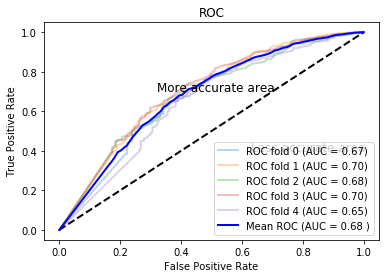

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import interp
x=test_X
y=test_Y
classifier =[]
classifier.append(RFmodel)
classifier.append(DTmodel)
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

i = 0
for train,test in cv.split(x,y):
    yscore = classifier[0].fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y.iloc[test], yscore[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()



 



# **Conclusion**

Among the four classification models used, Random Forest was the best perofrming model in terms of CV score. The CV score helps to evaluate how the model would perform on unseen data. When random forest model was applied to unseen data, the computed ROC_AUC score was 0.68 which is slightly les than the performance of the model (0.7057) on the training dataset. Further improvement requires hyperparameter tuning of the classification models and reducing collision loss during hash encoding. I hope to include them when I update this kernel in the future.
